In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
conn = sqlite3.connect("../data/traffic_data_cleaned.sqlite")
unique_races_query = "SELECT DISTINCT race FROM traffic_data"
unique_races = pd.read_sql_query(unique_races_query, conn)
print("Unique races:", unique_races)

Unique races:                      race
0                   white
1                     000
2                 unknown
3                   black
4  asian/pacific islander
5                hispanic
6                   other


In [6]:
states = ['New Hampshire', 'Rhode Island', 'Connecticut', 'Vermont', 'Massachusetts', 'Virginia']
state_results = {}

conn = sqlite3.connect("../data/traffic_data_cleaned.sqlite")

In [7]:
for state in states:
    query = f"""
    SELECT *,
           CASE WHEN race = '000' THEN 'Unidentified' ELSE race END AS race_cleaned
    FROM traffic_data
    WHERE state = '{state}'
    """
    state_data = pd.read_sql_query(query, conn)
    race_counts = state_data['race_cleaned'].value_counts()
    total_stops = len(state_data)
    race_counts['Total Stops'] = total_stops
    state_results[state] = race_counts
conn.close()

In [8]:
summary_df = pd.DataFrame(state_results).fillna(0).astype(int).T
summary_df.loc['Total'] = summary_df.sum()
summary_df = summary_df.reset_index().rename(columns={'index': 'State'})
print(summary_df)

           State  Total Stops  Unidentified  asian/pacific islander    black  \
0  New Hampshire       259822         93736                    2520     4128   
1   Rhode Island       509681         29073                   12826    68579   
2    Connecticut        18439             0                     176     7104   
3        Vermont       283285          3983                    3607     5741   
4  Massachusetts      3416238          1664                  166842   351610   
5       Virginia      5006847             0                  125413  1207078   
6          Total      9494312        128456                  311384  1644240   

   hispanic   other  unknown    white  
0      2629     124     2648   154037  
1     53125    1344        0   344734  
2      5073      29        0     6057  
3      2625     280      833   266216  
4    338317   11008    17017  2529780  
5    307345  100780    67481  3198750  
6    709114  113565    87979  6499574  


In [9]:
if 'Unidentified' in summary_df.columns and 'unknown' in summary_df.columns:
    summary_df['Unidentified'] = summary_df['Unidentified'] + summary_df['unknown']
    summary_df.drop(columns=['unknown'], inplace=True)


summary_df = summary_df[['State', 'Total Stops', 'white', 'asian/pacific islander', 'hispanic', 'black', 'other', 'Unidentified']]


summary_df.rename(columns={
    'Total Stops': 'Total Stops',
    'asian/pacific islander': 'Asian or Pacific Islander',
    'hispanic': 'Hispanic',
    'black': 'Black',
    'white': 'White',
    'other': 'Other',
    'Unidentified': 'Unidentified'
}, inplace=True)

print(summary_df)

           State  Total Stops    White  Asian or Pacific Islander  Hispanic  \
0  New Hampshire       259822   154037                       2520      2629   
1   Rhode Island       509681   344734                      12826     53125   
2    Connecticut        18439     6057                        176      5073   
3        Vermont       283285   266216                       3607      2625   
4  Massachusetts      3416238  2529780                     166842    338317   
5       Virginia      5006847  3198750                     125413    307345   
6          Total      9494312  6499574                     311384    709114   

     Black   Other  Unidentified  
0     4128     124         96384  
1    68579    1344         29073  
2     7104      29             0  
3     5741     280          4816  
4   351610   11008         18681  
5  1207078  100780         67481  
6  1644240  113565        216435  


In [10]:
latex_table = summary_df.to_latex(index=False, longtable=True)
with open("table/state_summary_table_cleaned.tex", "w") as file:
    file.write(latex_table)

In [ ]:
conn = sqlite3.connect("traffic_data_cleaned.sqlite")
states = ['Rhode Island', 'Connecticut', 'Vermont', 'Massachusetts', 'Virginia']


races = ['white', 'asian/pacific islander', 'hispanic', 'black']


search_ratios = []

for state in states:
    for race in races:
        query = f"""
        SELECT search_conducted
        FROM traffic_data
        WHERE state = '{state}' AND race = '{race}' AND search_conducted IN ('0', '1')
        """
        data = pd.read_sql_query(query, conn)

        total_valid = len(data)
        search_conducted_count = data['search_conducted'].astype(int).sum()


        #print(f"State: {state}, Race: {race}, Search Conducted: {search_conducted_count}, Total Valid: {total_valid}")

        if total_valid > 0:
            search_conducted_ratio = (search_conducted_count / total_valid) * 100
        else:
            search_conducted_ratio = 0

        search_ratios.append({
            'State': state,
            'Race': race.title().replace('Asian/Pacific Islander', 'Asian or Pacific Islander'),
            'Search Ratio (%)': search_conducted_ratio
        })

conn.close()

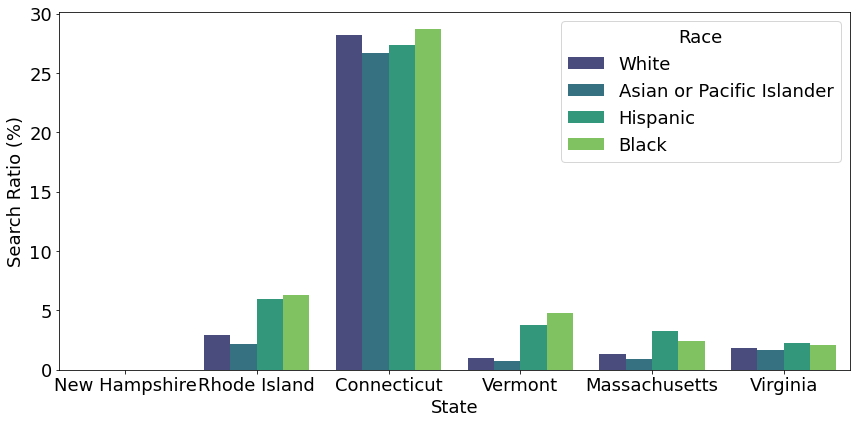

In [12]:
search_ratios_df = pd.DataFrame(search_ratios)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=search_ratios_df,
    x='State',
    y='Search Ratio (%)',
    hue='Race',
    palette='viridis'
)


#plt.title('Search Conducted Ratio by State and Race (Conducted vs Not Conducted)', fontsize=18)
plt.xlabel('State', fontsize=18)
plt.ylabel('Search Ratio (%)', fontsize=18)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)
plt.legend(title='Race', fontsize=18, title_fontsize=18)


plt.tight_layout()
plt.savefig("figure/search_ratio_by_state_and_race_conducted_vs_not_conducted.pdf")
#plt.savefig("figure/search_ratio_by_state_and_race_conducted_vs_not_conducted.png")
plt.show()

In [30]:
conn = sqlite3.connect("traffic_data_cleaned.sqlite")

query = """
SELECT race, 
       SUM(CASE WHEN arrest_made = '1' THEN 1 ELSE 0 END) AS arrests,
       SUM(CASE WHEN warning_issued = '1' THEN 1 ELSE 0 END) AS warnings
FROM traffic_data
WHERE race IS NOT NULL AND race != '000' AND race != 'other' AND race != 'unknown'
GROUP BY race
"""
data = pd.read_sql_query(query, conn)

conn.close()

In [31]:
data['race'] = data['race'].replace({
    'white': 'White',
    'asian/pacific islander': 'Asian or Pacific Islander',
    'hispanic': 'Hispanic',
    'black': 'Black'
})

data['total_outcomes'] = data['arrests'] + data['warnings']
data['arrest_rate'] = (data['arrests'] / data['total_outcomes']) * 100
data['warning_rate'] = (data['warnings'] / data['total_outcomes']) * 100


data = data.sort_values('race')

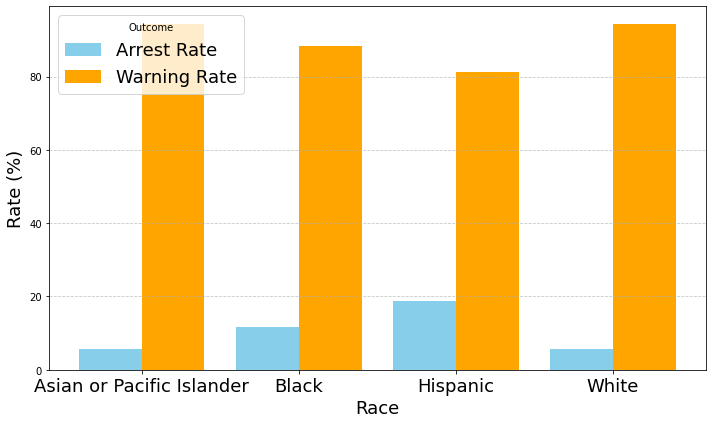

In [32]:
x = range(len(data['race']))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))


ax.bar([pos - width/2 for pos in x], data['arrest_rate'], width, label='Arrest Rate', color='skyblue')
ax.bar([pos + width/2 for pos in x], data['warning_rate'], width, label='Warning Rate', color='orange')


ax.set_xticks(x)
ax.set_xticklabels(data['race'], rotation=0, fontsize=18)
ax.set_xlabel('Race', fontsize=18)
ax.set_ylabel('Rate (%)', fontsize=18)
#ax.set_title('Arrest vs. Warning Rates by Race', fontsize=16)
ax.legend(title='Outcome', fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.savefig("figure/arrest_vs_warning_rates_by_race_normalized.pdf")
#plt.savefig("figure/arrest_vs_warning_rates_by_race_normalized.png")
plt.show()

In [34]:
conn = sqlite3.connect("traffic_data_cleaned.sqlite")

query = """
SELECT date, 
       SUM(CASE WHEN arrest_made = '1' THEN 1 ELSE 0 END) AS arrests_made,
       SUM(CASE WHEN warning_issued = '1' THEN 1 ELSE 0 END) AS warnings_issued
FROM traffic_data
WHERE date IS NOT NULL AND date != '000'
GROUP BY date
ORDER BY date
"""
data = pd.read_sql_query(query, conn)

conn.close()

In [35]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data = data.dropna(subset=['date'])

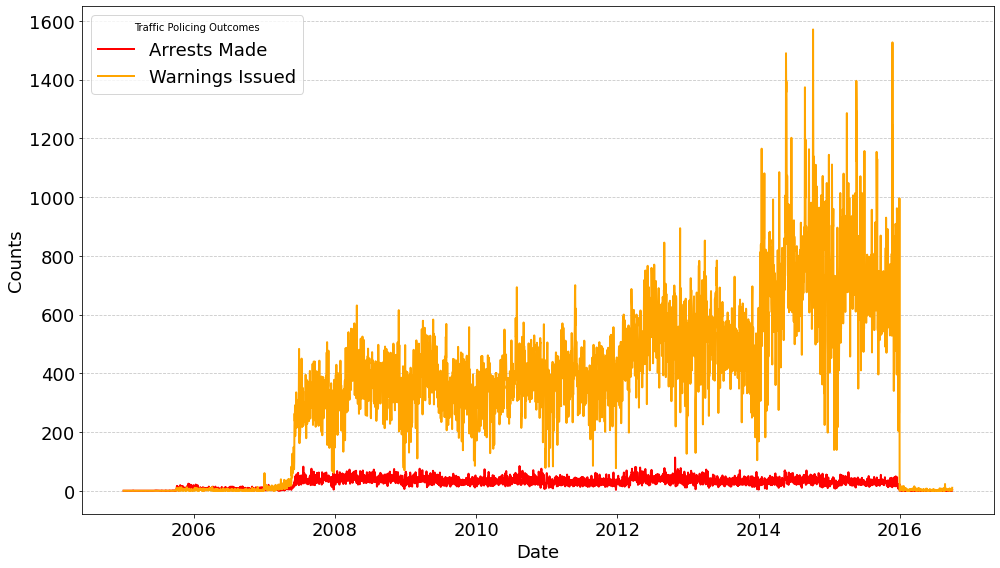

In [36]:
plt.figure(figsize=(14, 8))


plt.plot(data['date'], data['arrests_made'], label='Arrests Made', color='red', linewidth=2)
plt.plot(data['date'], data['warnings_issued'], label='Warnings Issued', color='orange', linewidth=2)

ax = plt.gca()  
ax.tick_params(axis='x', labelsize=18)
ay = plt.gca()
ay.tick_params(axis='y', labelsize=18)

#plt.title('Timeline of Arrests and Warnings Issued', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.legend(title='Traffic Policing Outcomes', fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("figure/timeline_arrests_and_warnings_counts.pdf")
#plt.savefig("figure/timeline_arrests_and_warnings_counts.png")
plt.show()

In [24]:
conn = sqlite3.connect("traffic_data_cleaned.sqlite")


query = """
SELECT race,
       SUM(CASE WHEN contraband_drugs = '1' THEN 1 ELSE 0 END) AS drugs,
       SUM(CASE WHEN contraband_weapons = '1' THEN 1 ELSE 0 END) AS weapons,
       SUM(CASE WHEN contraband_alcohol = '1' THEN 1 ELSE 0 END) AS alcohol,
       SUM(CASE WHEN contraband_other = '1' THEN 1 ELSE 0 END) AS other
FROM traffic_data
WHERE race IS NOT NULL AND race != '000' AND race != 'other' AND race != 'unknown'
GROUP BY race
"""
contraband_data = pd.read_sql_query(query, conn)
conn.close()

In [25]:
contraband_data['race'] = contraband_data['race'].replace({
    'white': 'White',
    'asian/pacific islander': 'Asian or Pacific Islander',
    'hispanic': 'Hispanic',
    'black': 'Black'
})


outer_labels = contraband_data['race']
outer_sizes = contraband_data[['drugs', 'weapons', 'alcohol', 'other']].sum(axis=1)


inner_sizes = contraband_data[['drugs', 'weapons', 'alcohol', 'other']].values.flatten()
inner_labels = ['Drugs', 'Weapons', 'Alcohol', 'Other'] * len(outer_labels)


contraband_colors = ['skyblue', 'orange', 'green', 'red']
inner_colors = contraband_colors * len(outer_labels)

outer_colors = plt.cm.Set3(range(len(outer_labels)))

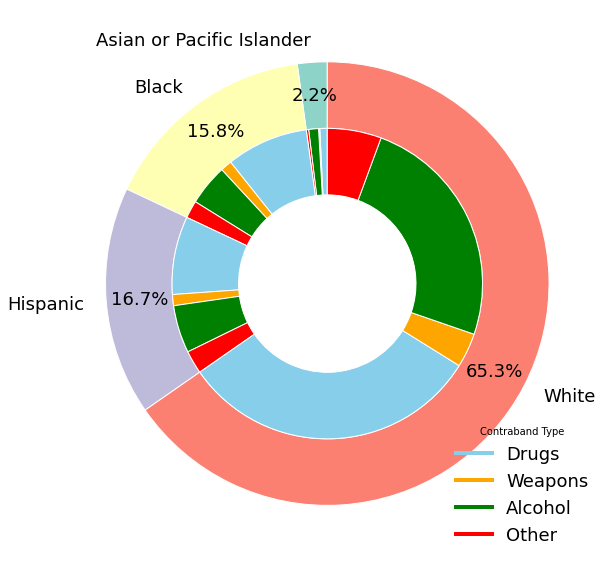

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))


ax.pie(
    outer_sizes,
    labels=outer_labels,
    radius=1,
    colors=outer_colors,
    startangle=90,
    autopct='%1.1f%%',
    pctdistance=0.85,
    wedgeprops=dict(width=0.3, edgecolor='white'),
    textprops={'fontsize': 18} 
)


ax.pie(
    inner_sizes,
    labels=None, 
    radius=0.7,
    colors=inner_colors,
    startangle=90,
    wedgeprops=dict(width=0.3, edgecolor='white')
)


handles = [
    plt.Line2D([0], [0], color=color, lw=4) for color in contraband_colors
]
labels = ['Drugs', 'Weapons', 'Alcohol', 'Other']
plt.legend(
    handles,
    labels,
    title="Contraband Type",
    loc="lower right",
    fontsize=18,
    frameon=False
)


center_circle = plt.Circle((0, 0), 0.4, color='white', fc='white', linewidth=0)
ax.add_artist(center_circle)

#plt.title('Contraband Distribution Among Races', fontsize=18)

plt.tight_layout()
plt.savefig("figure/contraband_distribution_nested_pie_fixed.pdf")
#plt.savefig("figure/contraband_distribution_nested_pie_fixed.png")
plt.show()

In [22]:
conn = sqlite3.connect("traffic_data_cleaned.sqlite")


races = ['asian/pacific islander', 'black', 'hispanic', 'white']
contraband_columns = ['contraband_drugs', 'contraband_weapons', 'contraband_alcohol', 'contraband_other']
contraband_labels = ['Drugs', 'Weapons', 'Alcohol', 'Other']


race_data = {}

for race in races:
    query = f"""
    SELECT {', '.join(contraband_columns)}, arrest_made, warning_issued
    FROM traffic_data
    WHERE race = '{race}' AND arrest_made IN ('0', '1') AND warning_issued IN ('0', '1')
    """
    data = pd.read_sql_query(query, conn)

    for column in contraband_columns:
        data = data[data[column] != '000']

    data[contraband_columns + ['arrest_made', 'warning_issued']] = data[contraband_columns + ['arrest_made', 'warning_issued']].astype(int)

    results = {}
    for column in contraband_columns:
        subset = data[data[column] == 1]
        total = len(subset)
        if total > 0:
            arrest_count = subset['arrest_made'].sum()
            warning_count = subset['warning_issued'].sum()
            total_outcomes = arrest_count + warning_count
            results[column] = {
                'Arrest': (arrest_count / total_outcomes) * 100,
                'Warning': (warning_count / total_outcomes) * 100
            }
        else:
            results[column] = {'Arrest': 0, 'Warning': 0}

    race_data[race] = results

conn.close()

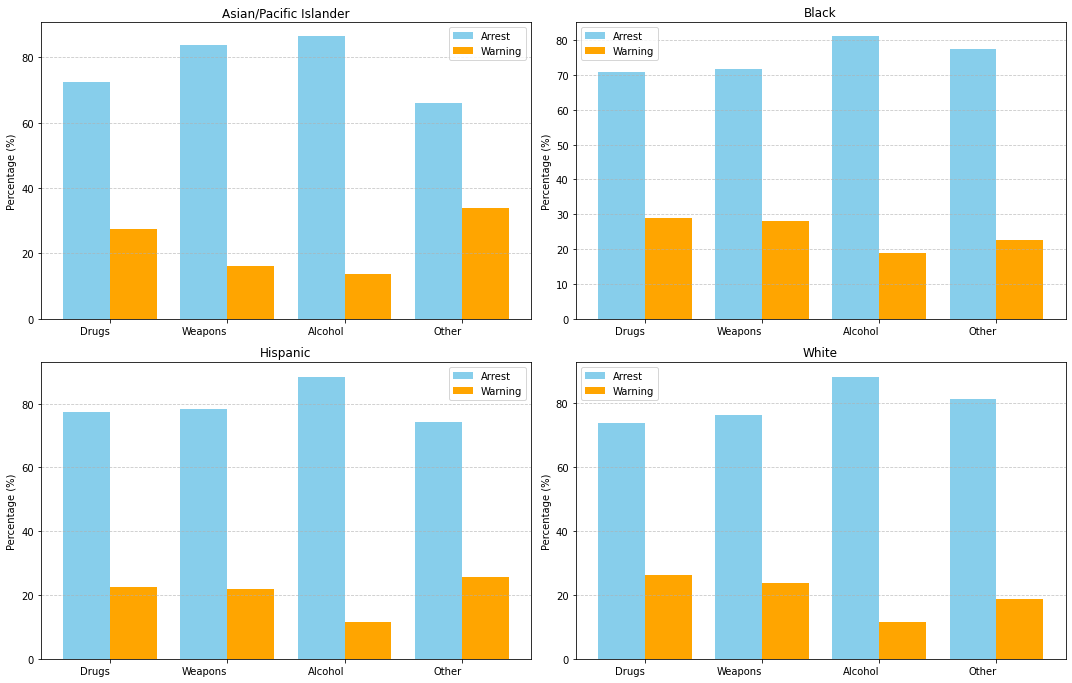

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
#fig.suptitle('Contraband Outcome Analysis by Race', fontsize=16)


race_positions = {
    'asian/pacific islander': (0, 0),
    'black': (0, 1),
    'hispanic': (1, 0),
    'white': (1, 1)
}

for race, position in race_positions.items():
    ax = axes[position]
    race_results = race_data[race]
    categories = contraband_labels
    arrest_rates = [race_results[cat]['Arrest'] for cat in contraband_columns]
    warning_rates = [race_results[cat]['Warning'] for cat in contraband_columns]

    x = range(len(categories))
    width = 0.4


    ax.bar([i - width/2 for i in x], arrest_rates, width, label='Arrest', color='skyblue')
    ax.bar([i + width/2 for i in x], warning_rates, width, label='Warning', color='orange')

    ax.set_title(race.title(), fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=0, ha='right')
    ax.set_ylabel('Percentage (%)', fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.savefig("figure/contraband_outcome_analysis_by_race_normalized.png")
plt.savefig("figure/contraband_outcome_analysis_by_race_normalized.pdf")
plt.show()